In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


In [2]:
path = r"C:\Users\USYS671257\OneDrive - WSP O365\21_31000110.002_Chattanooga TPO Model\model outputs"
use_zone_connectors = False
scenario = ["Base", "2025"]

In [3]:
def load_assignments(assignment_file, use_zone_connectors=False):

    use_columns = ["ID", "STATE", "COUNTYID", "COUNTY", "DOT_FC", "FUNCCLASS", "AB_LANES", "BA_LANES", "DOT_FCAREA", 
                    "DISTRICT", "SUPERDIST", "AREA_TYPE",
                    "FFTime", "FFSpeed",
                    "AB_AM_Time", "BA_AM_Time", "AB_PM_Time", "BA_PM_Time", "AB_OP_Time", "BA_OP_Time",
                   "AB_CAR_ADT", "BA_CAR_ADT", "AB_SUT_ADT", "BA_SUT_ADT", "AB_MUT_ADT", "BA_MUT_ADT"]

    assn_columns = ["AB_AM_Auto", "BA_AM_Auto", "AB_PM_Auto", "BA_PM_Auto", "AB_OP_Auto", "BA_OP_Auto",
                    "AB_AM_SUT", "BA_AM_SUT", "AB_PM_SUT", "BA_PM_SUT", "AB_OP_SUT", "BA_OP_SUT",
                    "AB_AM_MUT", "BA_AM_MUT", "AB_PM_MUT", "BA_PM_MUT", "AB_OP_MUT", "BA_OP_MUT"]

    assn =pd.read_csv(assignment_file,low_memory=False)[use_columns+assn_columns].copy()
    assn = assn.melt(id_vars=use_columns, var_name="COLUMN_NAME", value_name="FLOW")
    assn = assn[(assn["FLOW"] > 0) & (~assn["FLOW"].isnull())].copy()
    assn = assn.rename(columns={"ID": "LINK_ID"})

    if not use_zone_connectors:
        assn = assn[(assn["FUNCCLASS"] != 98)]

    new_columns = assn["COLUMN_NAME"].str.split("_", n = 2, expand = True)
    assn["DIR"]= new_columns[0]
    assn["TOD"]= new_columns[1]
    assn["VEH"]= new_columns[2]

    assn.loc[(assn["DIR"]=="AB") & (assn["TOD"]=="AM"), "TIME"] = assn["AB_AM_Time"]
    assn.loc[(assn["DIR"]=="AB") & (assn["TOD"]=="PM"), "TIME"] = assn["AB_PM_Time"]
    assn.loc[(assn["DIR"]=="AB") & (assn["TOD"]=="OP"), "TIME"] = assn["AB_OP_Time"]
    assn.loc[(assn["DIR"]=="BA") & (assn["TOD"]=="AM"), "TIME"] = assn["BA_AM_Time"]
    assn.loc[(assn["DIR"]=="BA") & (assn["TOD"]=="PM"), "TIME"] = assn["BA_PM_Time"]
    assn.loc[(assn["DIR"]=="BA") & (assn["TOD"]=="OP"), "TIME"] = assn["BA_OP_Time"]
    
    assn.loc[(assn["DIR"]=="AB") & (assn["VEH"]=="Auto"), "COUNTS"] = assn["AB_CAR_ADT"]
    assn.loc[(assn["DIR"]=="AB") & (assn["VEH"]=="SUT"), "COUNTS"] = assn["AB_SUT_ADT"]
    assn.loc[(assn["DIR"]=="AB") & (assn["VEH"]=="MUT"), "COUNTS"] = assn["AB_MUT_ADT"]
    assn.loc[(assn["DIR"]=="BA") & (assn["VEH"]=="Auto"), "COUNTS"] = assn["BA_CAR_ADT"]
    assn.loc[(assn["DIR"]=="BA") & (assn["VEH"]=="SUT"), "COUNTS"] = assn["BA_SUT_ADT"]
    assn.loc[(assn["DIR"]=="BA") & (assn["VEH"]=="MUT"), "COUNTS"] = assn["BA_MUT_ADT"]

    assn["LEN"] = assn["FFTime"]*assn["FFSpeed"]/(1/60.)
    assn["VMT"] = assn["FLOW"]*assn["LEN"]
    assn["VHT"] = assn["FLOW"]*assn["TIME"]*(1/60.)
    
    return assn

In [4]:
hwy_assn = []

for s in scenario:
    assignment_file = os.path.join(path, s, f"Network_{s}.csv")
    assn = load_assignments(assignment_file, use_zone_connectors=False)
    assn["SCENARIO"] = s
    hwy_assn.append(assn)
    
hwy_assn = pd.concat(hwy_assn)
hwy_assn.head()

,LINK_ID,STATE,COUNTYID,COUNTY,DOT_FC,FUNCCLASS,AB_LANES,BA_LANES,DOT_FCAREA,DISTRICT,...,FLOW,DIR,TOD,VEH,TIME,COUNTS,LEN,VMT,VHT,SCENARIO
0,111,TN,65.0,Hamilton,2,12.0,2,0.0,2,7.0,...,1258.123118,AB,AM,Auto,0.123637,NaN,517.054923,6.505188e+05,2.592509,Base
1,284,TN,65.0,Hamilton,2,12.0,1,0.0,2,7.0,...,220.991662,AB,AM,Auto,0.412141,NaN,1525.800940,3.371893e+05,1.517995,Base
3,1101,TN,65.0,Hamilton,4,16.0,2,2.0,2,7.0,...,743.907394,AB,AM,Auto,0.109459,NaN,320.543682,2.384548e+05,1.357123,Base
4,1198,TN,65.0,Hamilton,3,14.0,2,2.0,2,9.0,...,1877.785974,AB,AM,Auto,0.595981,15918.25,866.726629,1.627527e+06,18.652079,Base
5,1583,TN,65.0,Hamilton,4,16.0,2,1.0,2,8.0,...,464.772570,AB,AM,Auto,0.225534,NaN,548.920925,2.551234e+05,1.747034,Base


## summaries

In [5]:
# by time of day
hwy_assn.groupby(["TOD","SCENARIO"]).agg({"FLOW":"sum","VMT":"sum","VHT":"sum"}).unstack()#.to_clipboard(index=False, sep='\t')

FLOW                         VMT                \
SCENARIO          2025          Base          2025          Base   
TOD                                                                
AM        2.074943e+07  1.886957e+07  9.754339e+09  8.771132e+09   
OP        5.157104e+07  4.665976e+07  2.460755e+10  2.201933e+10   
PM        2.611992e+07  2.389587e+07  1.218235e+10  1.102737e+10   

                    VHT                 
SCENARIO           2025           Base  
TOD                                     
AM         70818.090541   61838.467182  
OP        210028.044514  173306.205842  
PM         95033.965891   82875.992219

In [6]:
# by vehicle type
hwy_assn.groupby(["VEH","SCENARIO"]).agg({"FLOW":"sum","VMT":"sum","VHT":"sum"}).unstack()#.to_clipboard(index=False, sep='\t')

FLOW                         VMT                \
SCENARIO          2025          Base          2025          Base   
VEH                                                                
Auto      8.781261e+07  8.014158e+07  4.012226e+10  3.636741e+10   
MUT       6.835232e+06  6.199024e+06  4.224804e+09  3.698994e+09   
SUT       3.792555e+06  3.084589e+06  2.197176e+09  1.751427e+09   

                    VHT                 
SCENARIO           2025           Base  
VEH                                     
Auto      326962.503283  280423.251631  
MUT        33440.291035   25875.247067  
SUT        15477.306628   11722.166545

In [7]:
# by district
hwy_assn.groupby(["DISTRICT","SCENARIO"]).agg({"FLOW":"sum","VMT":"sum","VHT":"sum"}).unstack()#.to_clipboard(index=False, sep='\t')

FLOW                         VMT                \
SCENARIO          2025          Base          2025          Base   
DISTRICT                                                           
1.0       7.847002e+06  7.132056e+06  2.245278e+09  2.011132e+09   
2.0       6.890071e+06  6.130001e+06  1.986483e+09  1.776473e+09   
3.0       4.072788e+06  3.793644e+06  1.352572e+09  1.253699e+09   
4.0       1.684221e+06  1.524810e+06  6.372070e+08  5.801892e+08   
5.0       2.368980e+06  1.958612e+06  1.916691e+09  1.611068e+09   
6.0       1.548163e+06  1.427125e+06  3.824307e+08  3.518170e+08   
7.0       6.253157e+06  5.661970e+06  3.176089e+09  2.838585e+09   
8.0       8.732277e+05  7.380802e+05  4.520156e+08  3.782532e+08   
9.0       8.300321e+06  7.606630e+06  3.887013e+09  3.503637e+09   
10.0      1.614741e+05  1.531778e+05  3.742098e+07  3.549910e+07   
11.0      1.581979e+06  1.408182e+06  1.374580e+09  1.233496e+09   
12.0      1.386837e+06  1.277236e+06  1.095137e+09  9.988779e+08   
13.0      4.805283e+06  4.654246e+06  1.868061e+09  1.746066e+09   
14.0      1.143703e+07  1.064765e+07  4.418762e+09  4.005649e+09   
15.0      1.341414e+07  1.197784e+07  7.304799e+09  6.472743e+09   
16.0      5.395795e+06  4.672727e+06  2.409908e+09  2.085536e+09   
17.0      1.413186e+06  1.226048e+06  1.046591e+09  9.141873e+08   
18.0      1.827209e+06  1.513632e+06  1.402327e+09  1.165039e+09   
19.0      4.830940e+06  4.613961e+06  2.080654e+09  1.991063e+09   
20.0      8.704718e+06  7.994915e+06  5.649557e+09  5.198316e+09   
21.0      3.643870e+06  3.312648e+06  1.820661e+09  1.666512e+09   

                   VHT                
SCENARIO          2025          Base  
DISTRICT                              
1.0       21358.402735  17192.052690  
2.0       22027.764134  17144.510192  
3.0       13496.965386  11475.387905  
4.0        6210.780762   5272.262697  
5.0       18566.175574  11698.586973  
6.0        3702.494582   3285.516158  
7.0       25829.675438  20794.505287  
8.0        4050.301452   3232.404149  
9.0       35550.465599  30201.522781  
10.0        255.964633    239.396189  
11.0       7310.368309   6377.951743  
12.0       6296.586797   5677.516195  
13.0      15443.134815  15106.455736  
14.0      37257.863273  34494.622127  
15.0      53288.779577  45566.429577  
16.0      19926.895451  17677.956052  
17.0       6210.576523   5271.294785  
18.0      11712.222056   6895.198259  
19.0      16511.409214  15677.670224  
20.0      37978.668392  33518.419193  
21.0      12894.606243  11221.006330

In [8]:
# by county
hwy_assn.groupby(["COUNTY","SCENARIO"]).agg({"FLOW":"sum","VMT":"sum","VHT":"sum"}).unstack()#.to_clipboard(index=False, sep='\t')

FLOW                         VMT                \
SCENARIO          2025          Base          2025          Base   
COUNTY                                                             
Catoosa   1.232384e+07  1.128529e+07  7.444599e+09  6.841199e+09   
Dade      1.913560e+06  1.585324e+06  1.414074e+09  1.174734e+09   
HAmilton  3.329000e+03  2.173688e+03  9.054733e+06  5.912335e+06   
Hamilton  7.927997e+07  7.185368e+07  3.555938e+10  3.177048e+10   
Walker    4.919704e+06  4.698732e+06  2.117136e+09  2.025513e+09   

                    VHT                 
SCENARIO           2025           Base  
COUNTY                                  
Catoosa    50735.601626   44612.954381  
Dade       11826.135353    6964.947089  
HAmilton      64.232883      41.833447  
Hamilton  296517.321322  250509.925247  
Walker     16736.809762   15891.005079

In [9]:
# by functional class
hwy_assn.groupby(["DOT_FC","SCENARIO"]).agg({"FLOW":"sum","VMT":"sum","VHT":"sum"}).unstack()#.to_clipboard(index=False, sep='\t')

FLOW                         VMT                \
SCENARIO          2025          Base          2025          Base   
DOT_FC                                                             
1         2.238011e+07  1.994022e+07  1.635216e+10  1.446462e+10   
2         7.031180e+06  6.396601e+06  5.258407e+09  4.770893e+09   
3         2.792493e+07  2.595955e+07  9.623020e+09  8.852459e+09   
4         3.206392e+07  2.916097e+07  1.091019e+10  9.873183e+09   
5         6.560640e+06  5.778228e+06  3.070557e+09  2.718792e+09   
6         8.711293e+05  7.535383e+05  6.458292e+08  5.488884e+08   
7         1.593860e+06  1.426035e+06  6.747048e+08  5.803248e+08   
91        4.272443e+03           NaN  4.392881e+05           NaN   
98        1.036317e+04  1.004582e+04  8.926318e+06  8.679955e+06   

                    VHT                
SCENARIO           2025          Base  
DOT_FC                                 
1         119540.568529  94121.132924  
2          27523.569082  24156.507510  
3          87416.724033  77820.669950  
4         101205.604622  87670.444005  
5          26181.441192  22492.801233  
6           6011.666565   5103.712351  
7           7918.285106   6588.568738  
91            12.576678           NaN  
98            69.665139     66.828532

## validation

In [12]:
val_assn = hwy_assn[~hwy_assn["COUNTS"].isna()].copy()

val_assn = (val_assn[val_assn["SCENARIO"]=="Base"].
                     groupby(["LINK_ID","DOT_FC","DIR","VEH","SCENARIO"]).
                     agg({"FLOW":"sum","COUNTS":"mean"}).
                     reset_index()
                     )

val_assn.head()

,LINK_ID,DOT_FC,DIR,VEH,SCENARIO,FLOW,COUNTS
0,3,2,AB,Auto,Base,32954.688129,33299.50
1,5,2,AB,Auto,Base,32974.000865,33079.00
2,5,2,AB,MUT,Base,986.501853,696.40
3,5,2,AB,SUT,Base,1922.999318,1044.60
4,7,2,AB,Auto,Base,6260.056955,7146.75


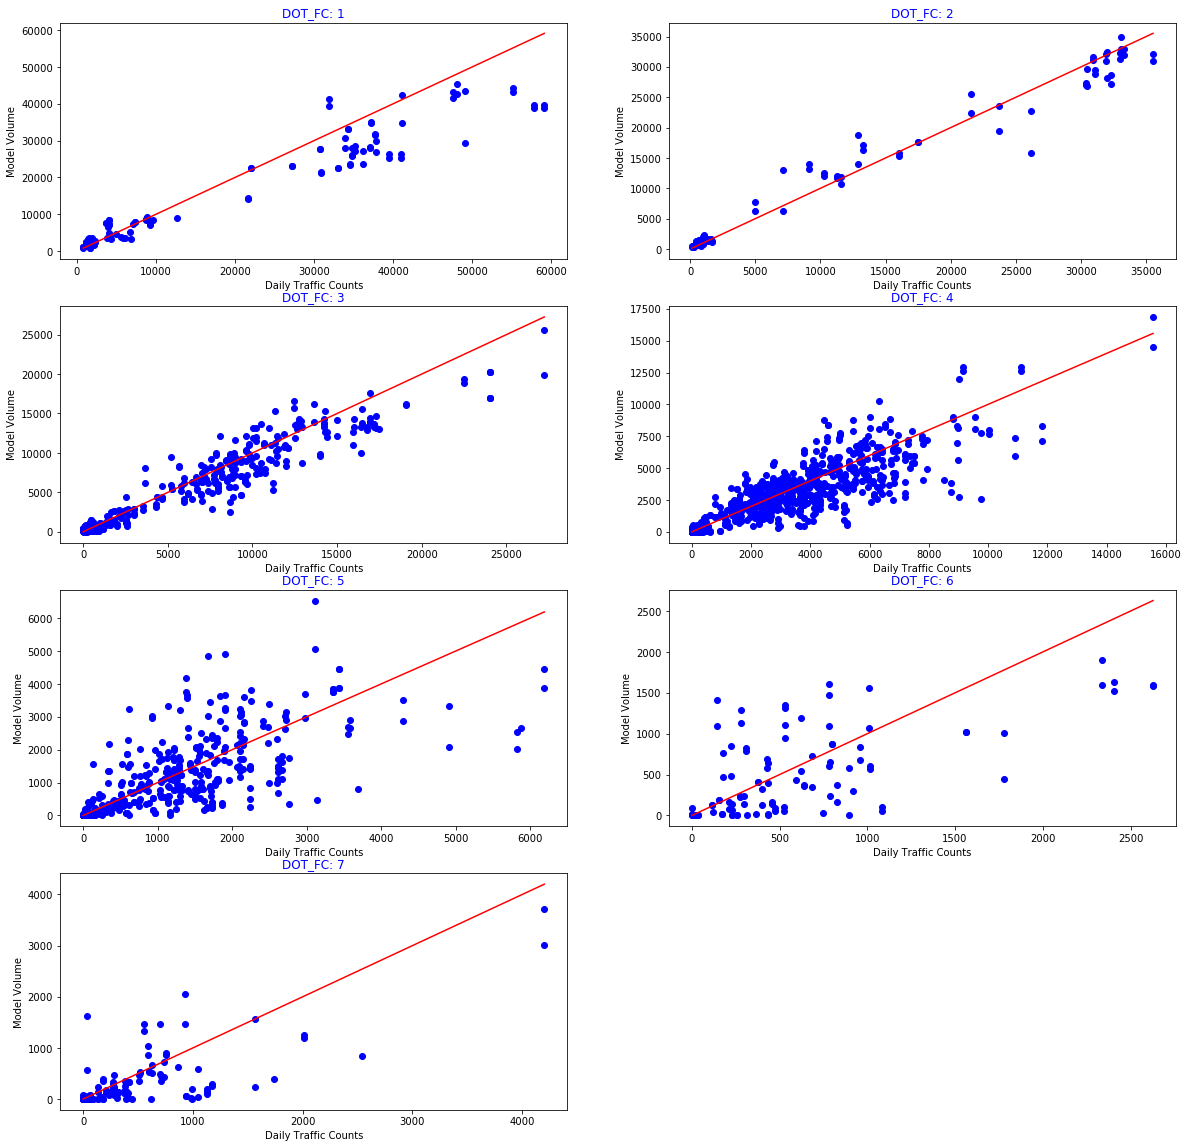

In [13]:
fig = plt.figure(figsize=(20,20))

groups = val_assn.groupby("DOT_FC")
for name, group in groups:

    number = 420+name
    lineStart = group["COUNTS"].min() 
    lineEnd = group["COUNTS"].max()
    
    ax = fig.add_subplot(number)
    ax.scatter("COUNTS", "FLOW", data=group[group['DOT_FC']==name], c="blue")
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
    ax.set_title(f"DOT_FC: {name}", color="blue")
    ax.set_xlabel("Daily Traffic Counts")
    ax.set_ylabel("Model Volume")

plt.show()